In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
pd.options.display.max_rows = 1000

# Import the pickled modeling data

In [2]:
partd = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/partd.pkl')
partb = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/partb.pkl')
dmepos = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/dmepos.pkl')
combined = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/combined.pkl')

# Making targets binary

In [3]:
partb.TARGET = partb.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
partd.TARGET = partd.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
dmepos.TARGET = dmepos.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
combined.TARGET = combined.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)

# Split data into train/test sets.

We have 4 datasets total, and in order to test to performance of each we need to split them into training/test sets. We have a lot of data, so we ***could*** create a holdout dataset to test our model. I think the better course of action would be to split the data into training/test sets, then perform K-fold cross validation to confirm the predictive power of the model.

In [4]:
# partb dataset
X_partb = partb.drop(columns=['TARGET'], axis=1)
y_partb = partb.TARGET

#partd dataset
X_partd = partd.drop(columns=['TARGET'], axis=1)
y_partd = partd.TARGET

#dmepos dataset
X_dmepos = dmepos.drop(columns=['TARGET'], axis=1)
y_dmepos = dmepos.TARGET

#combined dataset
X_combined = combined.drop(columns=['TARGET'], axis=1)
y_combined = combined.TARGET

# Downsampling

There is a massive class imbalance in the dataset, with most observations classified as `NOT_FRAUD`, to address this I chose to randomly downsample the majority class. This should still leave us with 2000+ observations in each dataset. [The research used to guide this project](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-018-0138-3) did not address class imbalance.

In [5]:
rus1 = RandomUnderSampler(random_state=42)
X_partb, y_partb = rus1.fit_sample(X_partb, y_partb)

rus2 = RandomUnderSampler(random_state=42)
X_partd, y_partd = rus2.fit_sample(X_partd, y_partd)

rus3 = RandomUnderSampler(random_state=42)
X_dmepos, y_dmepos = rus3.fit_sample(X_dmepos, y_dmepos)

rus4 = RandomUnderSampler(random_state=42)
X_combined, y_combined = rus4.fit_sample(X_combined, y_combined)

# Train/Test split

In [6]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_partb, y_partb, test_size=0.2, random_state=0)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_partd, y_partd, test_size=0.2, random_state=0)
X_train_dmepos, X_test_dmepos, y_train_dmepos, y_test_dmepos = train_test_split(X_dmepos, y_dmepos, test_size=0.2, random_state=0)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=0)

### Logistic Regression

L1 (Lasso) regression is used to remove the effect of coefficients that provide little predictive power. 

In [13]:
#instantiate the models
linreg_b = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
linreg_d = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
linreg_dmepos = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
linreg_combined = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')

#fit the models to the training data
linreg_b.fit(X_train_b, y_train_b)
linreg_d.fit(X_train_d, y_train_d)
linreg_dmepos.fit(X_train_dmepos, y_train_dmepos)
linreg_combined.fit(X_train_combined, y_train_combined)

LogisticRegression(max_iter=10000, penalty='l1', solver='saga')

In [14]:
#predict on the test set
y_pred_b = linreg_b.predict(X_test_b)
y_pred_d = linreg_d.predict(X_test_d)
y_pred_dmepos = linreg_dmepos.predict(X_test_dmepos)
y_pred_combined = linreg_combined.predict(X_test_combined)

In [22]:
from sklearn.model_selection import cross_val_score

cross_val_score(linreg_combined, X_combined, y_combined)

array([0.64393939, 0.6278481 , 0.59240506, 0.58987342, 0.57468354])

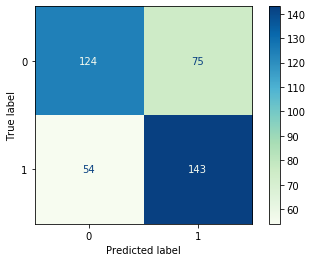

In [23]:
confusion_matrix = metrics.plot_confusion_matrix(linreg_combined, X_test_combined, y_test_combined, cmap= "GnBu")
confusion_matrix;

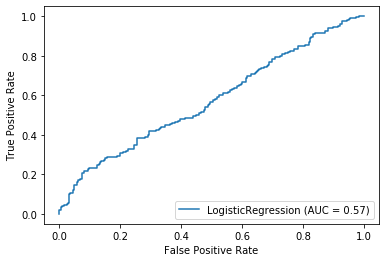

In [17]:
metrics.plot_roc_curve(linreg_dmepos, X_test_dmepos, y_test_dmepos); 

In [18]:
print(classification_report(y_test_dmepos, y_pred_dmepos))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64       248
           1       0.57      0.33      0.42       230

    accuracy                           0.56       478
   macro avg       0.56      0.55      0.53       478
weighted avg       0.56      0.56      0.54       478



# Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)

In [ ]:
param_grid_rf = {  
    'n_estimators': list(range(1,2000)),
    'criterion': ['gini','entropy'],
    'max_depth': list(range(1,50)),
    'min_samples_leaf': list(range(1,50,1)),
}

In [ ]:
grid_tree_rf = RandomizedSearchCV(rf, 
                                  param_grid_rf, 
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-1,
                                  scoring='f1'
                                
)

In [ ]:
grid_tree_rf.fit(X_train, y_train)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
rf_matrix = metrics.plot_confusion_matrix(grid_tree_rf, X_test, y_test, cmap= "GnBu", ax=ax)
ax.set_xticklabels(['NOT FRAUD','FRAUD'])
ax.set_yticklabels(['NOT FRAUD','FRAUD'])
rf_matrix;

In [ ]:
ypred = grid_tree_rf.predict(X_test)

In [ ]:
y_pred_prob = grid_tree_rf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr);

In [ ]:
roc_auc_score(y_test, ypred)

In [ ]:
print(classification_report(y_test, ypred))

In [ ]:
grid_tree_rf.best_params_